# BOLTZMAN MACHINE

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
from torchvision import datasets, transforms
# progress bar
import tqdm
from torchvision.utils import make_grid
import torch.distributions as tdist
import numpy as np
import matplotlib.pyplot as plt
import pdb


BATCH_SIZE = 100
EPOCHS = 100
VISIBLE_SIZE = 784
HIDDEN_SIZE = 100

In [0]:
# Loading MNIST dataset 
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./files', train=True, download=True,
                               transform=torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor()])), 
                                   batch_size=BATCH_SIZE, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./files', train=False, download=True,
                               transform=torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor()
                               ])), batch_size=BATCH_SIZE)

In [0]:
def visualize_RBM_weights(weights, grid_width, grid_height, slice_shape=(28, 28)):
    for idx in range(0, grid_width * grid_height):
        plt.subplot(grid_height, grid_width, idx+1)
        plt.imshow(weights[..., idx].reshape(slice_shape))
        plt.axis('off')

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def draw_rec(inp, title, size, Nrows, in_a_row, j):
    plt.subplot(Nrows, in_a_row, j)
    plt.imshow(inp.reshape(size), vmin=0, vmax=1, interpolation="nearest")
    plt.title(title)
    plt.axis('off')
    
def reconstruct(ind, states, orig, weights, biases, h1_shape=(10, 10), v_shape=(28,28)):
    j = 1
    in_a_row = 6
    Nimg = states.shape[1] + 3
    Nrows = int(np.ceil(float(Nimg+2)/in_a_row))
    plt.figure(figsize=(12, 2*Nrows))
    draw_rec(states[ind], 'states', h1_shape, Nrows, in_a_row, j)
    j += 1
    draw_rec(orig[ind], 'input', v_shape, Nrows, in_a_row, j)
    reconstr = biases.copy()
    j += 1
    draw_rec(sigmoid(reconstr), 'biases', v_shape, Nrows, in_a_row, j)
    for i in range(h1_shape[0] * h1_shape[1]):
        if states[ind,i] > 0:
            j += 1
            reconstr = reconstr + weights[:,i]
            titl = '+= s' + str(i+1)
            draw_rec(sigmoid(reconstr), titl, v_shape, Nrows, in_a_row, j)
    plt.tight_layout()

In [0]:
class RBM():
    def __init__(self, visible_size, hidden_size, cd_k=1):
        self.v_size = visible_size
        self.h_size = hidden_size
        self.cd_k = cd_k
        normal_dist = tdist.Normal(0, 0.1)
        self.W = torch.Tensor(normal_dist.sample(sample_shape=(self.v_size, self.h_size)))
        self.v_bias = torch.Tensor(torch.zeros(self.v_size))
        self.h_bias = torch.Tensor(torch.zeros(self.h_size))

    def forward(self, batch):
        return self._cd_pass(batch)
    
    def __call__(self, batch):
        return self.forward(batch)
    
    def _cd_pass(self, batch):
        """
          Constructive divegence pass, 
          batch : batch x visible
        """
        batch = batch.view(-1, 784)
        h0_prob = sigmoid(batch @ self.W) + self.h_bias 
        # batch x hidden
        h0 = h0_prob.bernoulli()
        h1 = h0
        for step in range(0, self.cd_k):
            v1_prob = sigmoid(h1 @ self.W.T) + self.v_bias 
            v1 = v1_prob.bernoulli()
            h1_prob = sigmoid(v1 @ self.W) + self.h_bias 
            h1 = h1_prob.bernoulli()
        return h0_prob, h0, h1_prob, h1, v1_prob, v1
    
    def reconstruct(self, h, gibbs_steps=None):
        h1 = h
        steps_to_do = self.cd_k
        if gibbs_steps is not None:
            steps_to_do = gibbs_steps
        for step in range(0, steps_to_do):
            v1_prob = ...
            v1 = ...
            h1_prob = ... 
            h1 =  ...
        return h1_prob, h1, v1_prob, v1

    def update_weights_for_batch(self, batch, learning_rate=0.01):
        h0_prob, h0, h1_prob, h1, v1_prob, v1 = self._cd_pass(batch)
        pdb.set_trace()
        # v1 ... B x 784
        # h  ... B x 100
        w_positive_grad = v1.T @ h0
        w_negative_grad = v1.T @ h1
        
        b_negative_grad = h0.mean(axis=0) - h1.mean(axis=0)
        c_negative_grad = v1.mean(axis=0) - v

        dw = (w_positive_grad - w_negative_grad) / batch.shape[0]
        db = h0.mean() - h1.mean()
        dc = batch.mean() - v1.mean()

        self.W = self.W + learning_rate*dw
        self.v_bias = self.v_bias + learning_rate*db
        self.h_bias = self.h_bias + learning_rate*dc


In [45]:

model = RBM(visible_size=VISIBLE_SIZE, hidden_size=HIDDEN_SIZE, cd_k=1)
# Learning hidden representations
for curr_epoch in tqdm.tqdm(range(0, EPOCHS)):
    for sample, label in train_loader:
        sample = sample.view(-1, 784)
        model.update_weights_for_batch(sample, 0.1)












  0%|          | 0/100 [00:00<?, ?it/s]

> <ipython-input-42-12cf11bb672b>(51)update_weights_for_batch()
-> w_positive_grad = v1.T @ h0
(Pdb) h0
tensor([[1., 0., 0.,  ..., 1., 1., 1.],
        [1., 0., 1.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        ...,
        [1., 0., 0.,  ..., 0., 1., 0.],
        [1., 0., 1.,  ..., 0., 0., 0.],
        [1., 0., 1.,  ..., 1., 1., 0.]])
(Pdb) h0.shape
torch.Size([100, 100])
(Pdb) v
*** NameError: name 'v' is not defined
(Pdb) v1
tensor([[0., 0., 1.,  ..., 0., 1., 1.],
        [0., 1., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        ...,
        [0., 1., 1.,  ..., 1., 0., 0.],
        [1., 1., 0.,  ..., 1., 0., 1.],
        [0., 1., 0.,  ..., 0., 0., 0.]])
(Pdb) v1.shape
torch.Size([100, 784])
(Pdb) v1.mean(axis=1)
tensor([0.5344, 0.4923, 0.4962, 0.4911, 0.5128, 0.5255, 0.4987, 0.5089, 0.5000,
        0.5255, 0.4936, 0.5204, 0.5459, 0.5459, 0.5293, 0.5115, 0.5485, 0.5077,
        0.4987, 0.5153, 0.4923, 0.5000, 0.5038, 0.5166, 0.5268, 0.4809, 0.

BdbQuit: ignored

In [1]:
plt.figure(figsize=(12, 12), facecolor='w')
visualize_RBM_weights(model.W.data, 10, 10)

sample, _ = next(iter(test_loader))
sample = sample.view(-1, 784)

for idx in range(0, 20): 
    h0_prob, h0, h1_prob, h1, v1_prob, v1 = model(sample)

    plt.figure(figsize=(8, 4), facecolor='w')
    plt.subplot(1, 3, 1)
    plt.imshow(sample[idx, ...].view(28, 28).cpu())
    if idx == 0:
        plt.title("Original image")

    plt.subplot(1, 3, 2)
    recon_image = v1_prob[idx, ...].view(28, 28)
    plt.imshow(recon_image.cpu().data)
    if idx == 0:
        plt.title("Reconstruction")
    
    plt.subplot(1, 3, 3)
    state_image = h1[idx, ...].view(10, 10)
    plt.imshow(state_image.cpu().data)
    if idx == 0:
        plt.title("Hidden state")

sample, _ = next(iter(test_loader))
sample = sample[0, ...].view(-1, 784)

h0_prob, h0, h1_prob, h1, v1_prob, v1 = model(sample)

reconstruct(0, h1.numpy(), sample.numpy(), model.W.numpy(), model.v_bias.numpy())

sample, _ = next(iter(test_loader))
sample = sample.view(-1, 784)

h0_prob, h0, h1_prob, h1, v1_prob, v1 = model(sample)

h0_prob, h0, h1_prob, h1, v1_prob, v1, model_weights, model_v_biases = list(map(lambda x: x.numpy(), [h0_prob, h0, h1_prob, h1, v1_prob, v1, model.W, model.v_bias]))


# Vjerojatnost da je skriveno stanje uključeno kroz Nu ulaznih uzoraka
plt.figure(figsize=(9, 4))
tmp = (h1.sum(0)/h1.shape[0]).reshape((10, 10))
plt.imshow(tmp, vmin=0, vmax=1, interpolation="nearest")
plt.axis('off')
plt.colorbar()
plt.title('vjerojatnosti (ucestalosti) aktivacije pojedinih neurona skrivenog sloja')

# Vizualizacija težina sortitranih prema učestalosti
plt.figure(figsize=(16, 16))
tmp_ind = (-tmp).argsort(None)
visualize_RBM_weights(model_weights[:, tmp_ind], 10, 10)
plt.suptitle('Sortirane matrice tezina - od najucestalijih do najmanje koristenih')

r_input = np.random.rand(100, HIDDEN_SIZE)
r_input[r_input > 0.9] = 1 # postotak aktivnih - slobodno varirajte
r_input[r_input < 1] = 0
r_input = r_input * 20 # pojačanje za slučaj ako je mali postotak aktivnih

s = 10
i = 0
r_input[i,:] = 0
r_input[i,i]= s
i += 1
r_input[i,:] = 0
r_input[i,i]= s
i += 1
r_input[i,:] = 0
r_input[i,i]= s
i += 1
r_input[i,:] = 0
r_input[i,i]= s
i += 1
r_input[i,:] = 0
r_input[i,i]= s
i += 1
r_input[i,:] = 0
r_input[i,i]= s
i += 1
r_input[i,:] = 0
r_input[i,i]= s

h1_prob, h1, v1_prob, v1 = model.reconstruct(torch.from_numpy(r_input).float(), 19)

plt.figure(figsize=(16, 16))
for idx in range(0, 19):
    plt.figure(figsize=(14, 4))
    
    plt.subplot(1, 3, 1)
    plt.imshow(r_input[idx, ...].reshape(10, 10))
    if idx == 0:
        plt.title("Set state")
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(h1[idx, ...].view(10, 10))
    if idx == 0:
        plt.title("Final state")
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(v1_prob[idx, ...].view(28, 28))
    if idx == 0:
        plt.title("Reconstruction")
    plt.axis('off')

NameError: ignored

#VARIJACIJSKI AUTOENKODER

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim

from torchvision import datasets, transforms
import tqdm
from torchvision.utils import make_grid

import torch.distributions as tdist

import numpy as np
import tqdm
import pdb

import seaborn as sns
import pandas as pd

import matplotlib.pyplot as plt

In [0]:
class VAE(nn.Module):
  def __init__(self, latent_size):
    super(VAE, self).__init__()
    self.latent_size = latent_size
    
    self.encoder1 = nn.Linear(784, 200)
    self.encoder2 = nn.Linear(200, 200)
    self.encoder_mu = nn.Linear(200, latent_size)
    self.encoder_var = nn.Linear(200, latent_size)

    self.decoder1 = nn.Linear(latent_size, 200)
    self.decoder2 = nn.Linear(200, 200)
    self.decoder3 = nn.Linear(200, 784)


  def encode(self, x):
    h1 = F.softplus(self.encoder1(x))
    h2 = F.softplus(self.encoder2(h1))
    mu  = self.encoder_mu(h2)
    var = self.encoder_var(h2)
    return mu, var                 

  def reparametrize(self, mu, logvar):
    # reparametrization trick
    std = torch.exp(0.5*logvar)
    epsilon = torch.normal(mean=torch.zeros_like(std), std=std)        
    return epsilon*std + mu

  def decode(self, z):
    h1 = F.softplus(self.decoder1(z))
    h2 = F.softplus(self.decoder2(h1))
    prob = torch.sigmoid(self.decoder3(h2))
    return prob

  def forward(self, x):
    mu, logvar = self.encode(x.view(-1, 784))
    z = self.reparametrize(mu, logvar)
    reconstruction = self.decode(z)
    return reconstruction, z, mu, logvar

  @staticmethod
  def loss_fn(reconstruction, batch, mu, logvar):
    crossentropy = F.binary_cross_entropy(reconstruction.view(-1, 784), batch.view(-1, 784), reduction='sum')
    kl_div = -0.5*torch.sum(1+logvar-mu.pow(2)-logvar.exp())
    return crossentropy + kl_div




In [0]:
def prepare_data_loaders(batch_size=32):
  """
    train and test data loaders
  """
  train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./files', train=True, download=True,
                              transform=torchvision.transforms.Compose([
                                  torchvision.transforms.ToTensor()
                              ])), batch_size=batch_size)

  test_loader = torch.utils.data.DataLoader(
      torchvision.datasets.MNIST('./files', train=False, download=True,
                                  transform=torchvision.transforms.Compose([
                                      torchvision.transforms.ToTensor()
                                  ])), batch_size=batch_size)
  return train_loader, test_loader

def train(model, n_epochs=10, log_epochs=1, batch_size=32, learning_rate=1e-3, device='cpu'):
  """
    Train VAE with given hyperparameters
  """
  train_loader, test_loader = prepare_data_loaders(batch_size)
  model = model.to(device)
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)
  model.train()
  for epoch_idx in range(0, n_epochs):
      train_loss = 0
      for batch_idx, (image_data, _) in enumerate(train_loader):
          image_data = image_data.to(device).squeeze(1)
          optimizer.zero_grad()
          reconstructed_batch, batch_z, batch_mu, batch_logvar = model(image_data)
          loss = model.loss_fn(reconstructed_batch, image_data, batch_mu, batch_logvar)
          train_loss += loss.item()
          loss.backward()
          optimizer.step()
      if epoch_idx % log_epochs == 0:
          print(f"Epoch {epoch_idx+1}/{n_epochs}: {train_loss / (len(train_loader) * train_loader.batch_size):.2f}")
  model.eval()
  return model

def plot_reconstructions(model, device='cpu', number_of_samples=10, state_shape=(4, 5)):
  """
    Draws original image, reconstructed image and latent variables
  """
  train_loader, test_loader = prepare_data_loaders(batch_size=number_of_samples)
  batch, _ = next(iter(test_loader))
  recons, zs, mus, logvars = model(batch.to(device))
  for idx in range(0, number_of_samples):
      original_image = batch[idx].view(28, 28).data.cpu()
      recon_image = recons[idx].view(28, 28).data.cpu()
      state = zs[idx].view(*state_shape).data.cpu()
      plt.figure(figsize=(8, 4))
      plt.subplot(1, 3, 1)
      plt.imshow(original_image)
      plt.subplot(1, 3, 2)
      plt.imshow(recon_image)
      plt.subplot(1, 3, 3)
      plt.imshow(state)
      plt.clim(-4, 4)
      plt.colorbar()

def generate_latent_dataframes(model, data_loader):
  """
    Gets calculated every mu and logvar in latent vector
     and gets weight matrix for first decoder layer 
  """
  mu_acc, logvar_acc, label_acc = [], [], []
  # saving mu, logvar and labels
  for image_data, label in tqdm.tqdm(data_loader):
    mu, logvar = model.encode(image_data.view(-1, 784).to('cuda'))
    mu_acc.extend(mu.data.cpu().numpy())
    logvar_acc.extend(logvar.data.cpu().numpy())
    label_acc.extend(label.data.cpu().numpy())
  mu_acc, logvar_acc = np.array(mu_acc), np.array(logvar_acc)
  tmp = {'label': label_acc}
  for idx in range(0, mu_acc.shape[1]):
    tmp[f'mu_z{idx}'] = mu_acc[..., idx]
  df_mu = pd.DataFrame(tmp)
  df_mu['label'] = df_mu['label'].astype('category')
  tmp = {'label': label_acc}
  for idx in range(0, mu_acc.shape[1]):
      tmp[f'logvar_z{idx}'] = np.square(np.exp(logvar_acc[..., idx]))
  df_logvar = pd.DataFrame(tmp)
  df_logvar['label'] = df_logvar['label'].astype('category')
  tmp = {}
  for idx in range(0, model.decoder1.weight.T.shape[0]):
      tmp[f'w{idx}'] = list(model.decoder1.weight.T[idx, ...].data.cpu().numpy())
  df_dec1_weights = pd.DataFrame(tmp)
  return df_mu, df_logvar, df_dec1_weights

def plot_data_boxplots(df_mu, df_logvar, df_dec1_weights, baseline_figsize=(1.2, 6), latent_size=20):
  """
    Draws box plots for mu, logvar and weights distributions
  """
  figwidth, figheight = baseline_figsize
  df_mu2 = df_mu.melt(['label'])
  plt.figure(figsize=(int(figwidth * latent_size), figheight))
  sns.boxplot(x='variable', y='value', data=df_mu2)
  plt.title("Distribution of $\mu$ in latent space")
  df_logvar2 = df_logvar.melt(['label'])
  plt.figure(figsize=(int(figwidth * latent_size), figheight))
  sns.boxplot(x='variable', y='value', data=df_logvar2)
  plt.title("Distribution of $\sigma^2$ in latent space")
  df_dec1_weights2 = df_dec1_weights.melt()
  plt.figure(figsize=(int(figwidth * latent_size), figheight))
  sns.boxplot(x='variable', y='value', data=df_dec1_weights2)
  plt.title("Weights going to decoder from latent space")

def walk_in_latent_space(latent_space_abs_limit=3, sqrt_sample_count=20, latent_size=2, dimensions_to_walk=(0, 1), figsize=(16, 16)):
  canvas = np.zeros((sqrt_sample_count * 28, sqrt_sample_count * 28))
  d1 = np.linspace(-latent_space_abs_limit, latent_space_abs_limit, num=sqrt_sample_count)
  d2 = np.linspace(-latent_space_abs_limit, latent_space_abs_limit, num=sqrt_sample_count)
  D1, D2 = np.meshgrid(d1, d2)
  synthetic_representations = np.array([D1.flatten(), D2.flatten()]).T
  recons = model.decode(torch.from_numpy(synthetic_representations).cuda().float())
  for idx in range(0, sqrt_sample_count * sqrt_sample_count):
      x, y = np.unravel_index(idx, (sqrt_sample_count, sqrt_sample_count))
      canvas[(sqrt_sample_count - 1 - x) * 28:((sqrt_sample_count - 1 - x + 1) * 28), y * 28:((y + 1) * 28)] = recons[idx, ...].view(28, 28).data.cpu().numpy()
  plt.figure(figsize=figsize)
  plt.imshow(canvas)


In [47]:
LATENT_SIZE = 20
model = VAE(LATENT_SIZE)
model = train(model, batch_size=1024, device='cuda', n_epochs=100, log_epochs=10, learning_rate=3.24e-4)

Epoch 1/100: 305.36
Epoch 11/100: 164.23
Epoch 21/100: 133.96
Epoch 31/100: 120.28
Epoch 41/100: 112.53
Epoch 51/100: 107.48
Epoch 61/100: 104.39
Epoch 71/100: 102.20
Epoch 81/100: 100.43
Epoch 91/100: 98.94


100%|██████████| 313/313 [00:00<00:00, 399.82it/s]


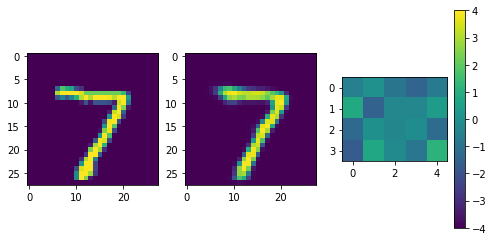

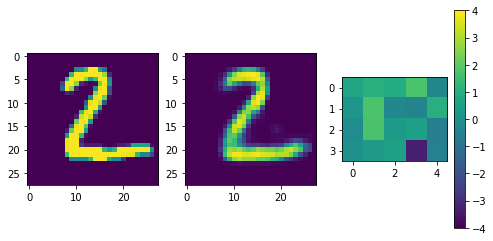

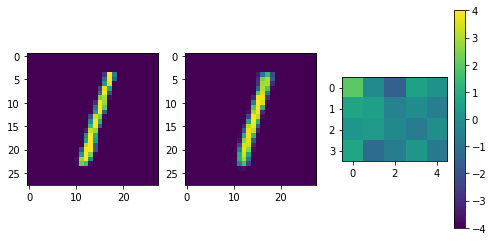

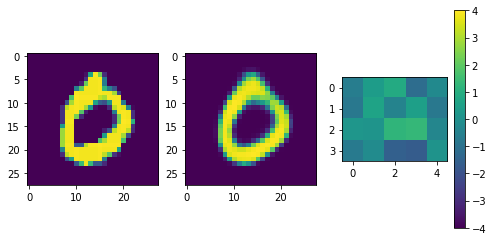

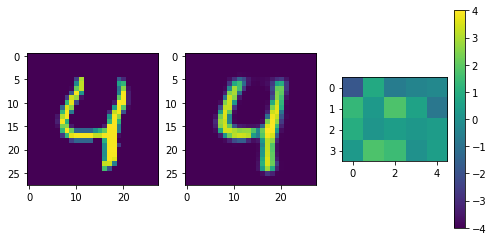

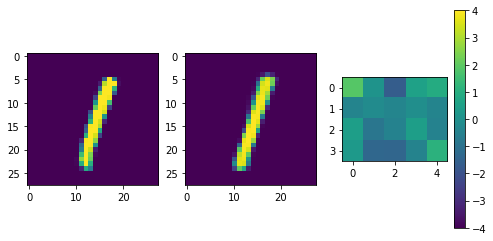

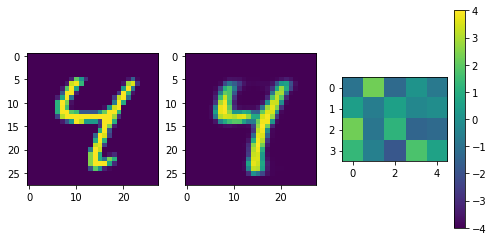

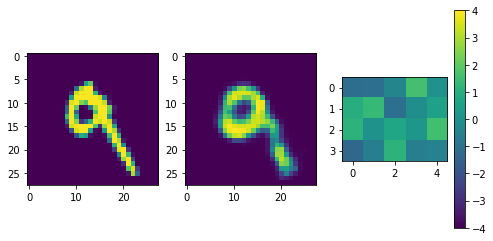

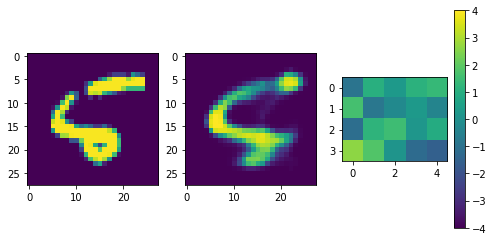

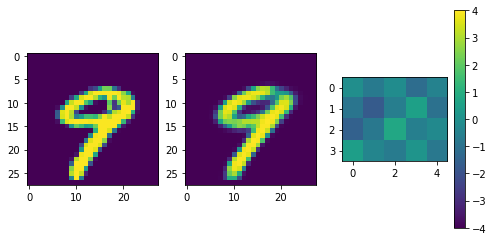

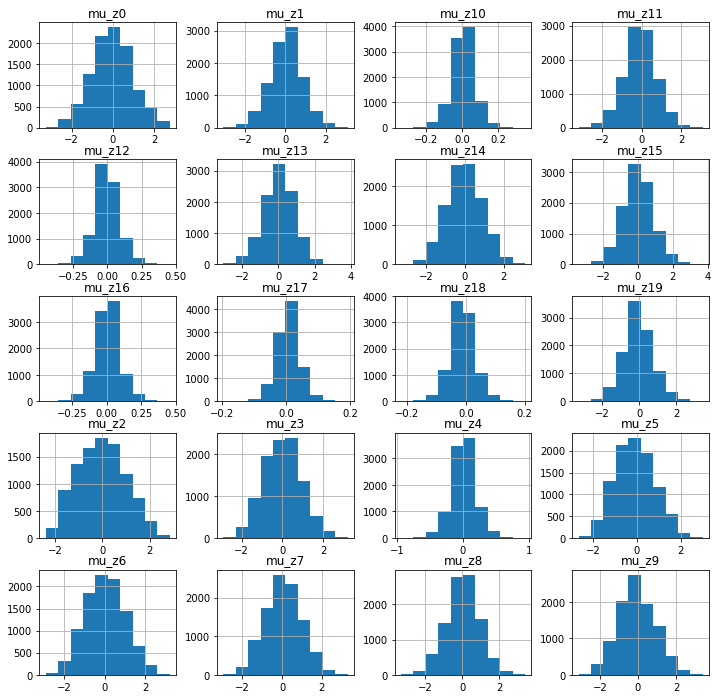

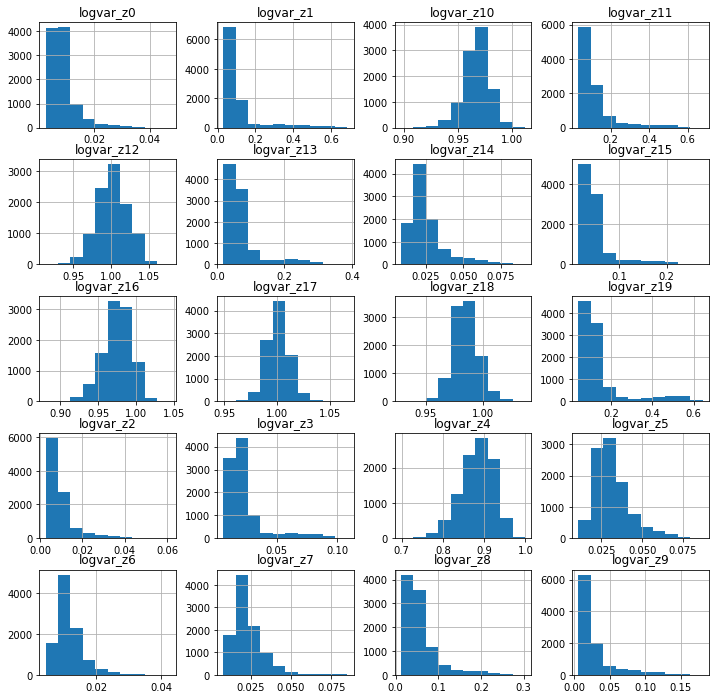

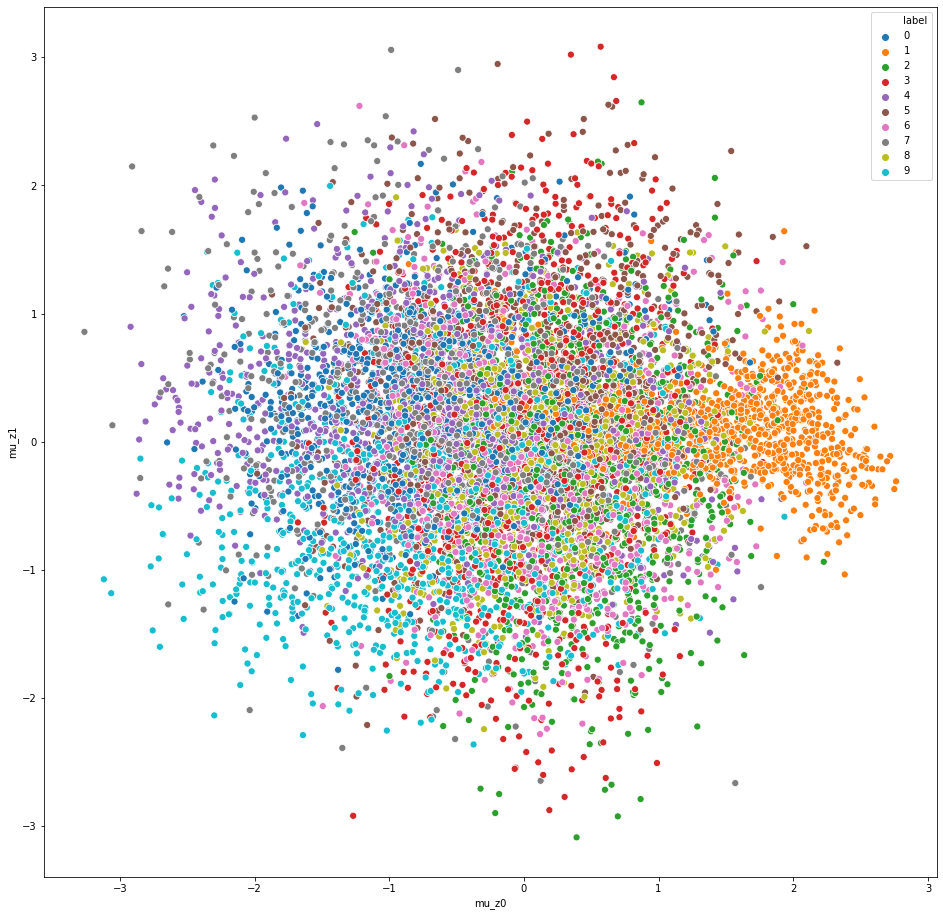

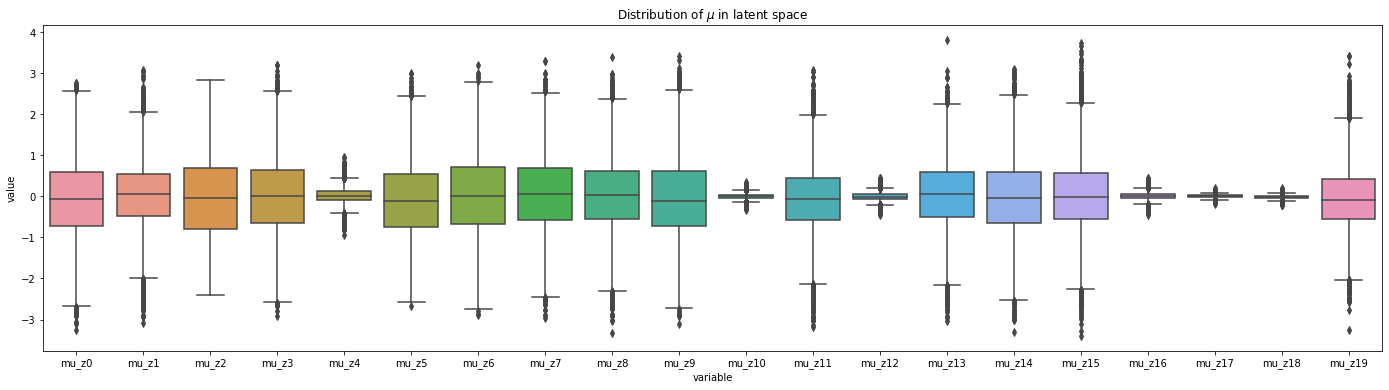

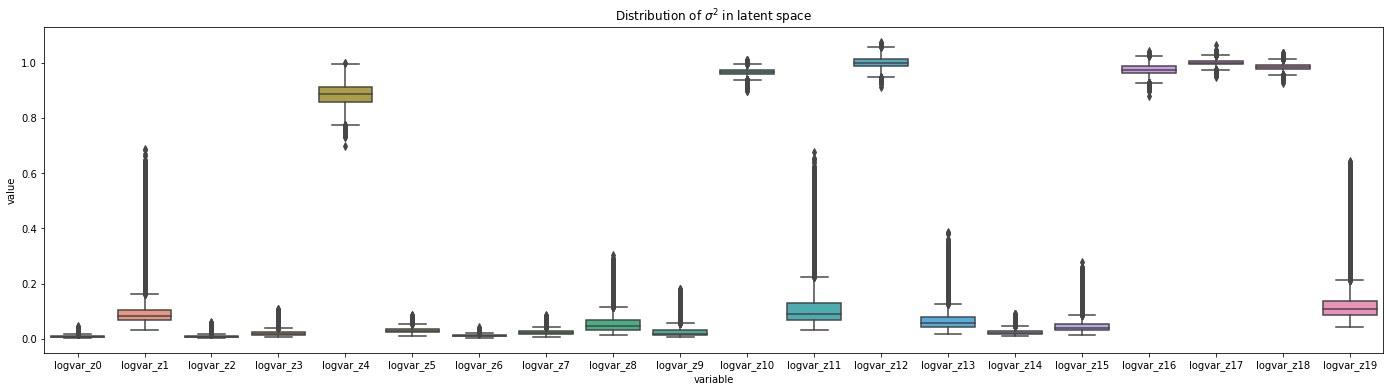

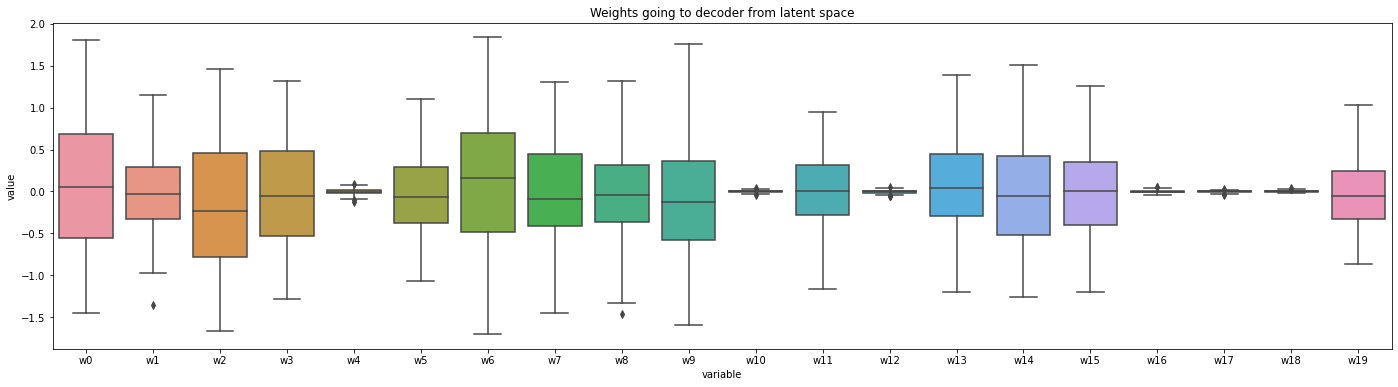

In [115]:
plot_reconstructions(model, 'cuda', state_shape=(4, 5))

_, test_loader = prepare_data_loaders()
df_mu, df_logvar, df_dec1_weights = generate_latent_dataframes(model, test_loader)
_ = df_mu.hist(figsize=(12,12))
_ = df_logvar.hist(figsize=(12,12))

plt.figure(figsize=(16, 16))
sns.scatterplot(x='mu_z0', y='mu_z1', hue='label', s=50, data=df_mu)
plot_data_boxplots(df_mu, df_logvar, df_dec1_weights)


In [107]:
LATENT_SIZE = 2
model2 = VAE(LATENT_SIZE)
model2 = train(model2, batch_size=1024, device='cuda', n_epochs=100, log_epochs=10, learning_rate=3.24e-4)

Epoch 1/100: 302.32
Epoch 11/100: 175.71
Epoch 21/100: 166.60
Epoch 31/100: 161.91
Epoch 41/100: 159.08
Epoch 51/100: 156.67
Epoch 61/100: 154.44
Epoch 71/100: 152.72
Epoch 81/100: 151.32
Epoch 91/100: 150.10


100%|██████████| 313/313 [00:00<00:00, 400.50it/s]


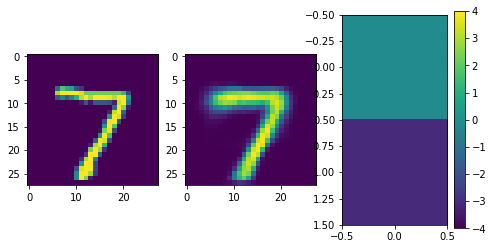

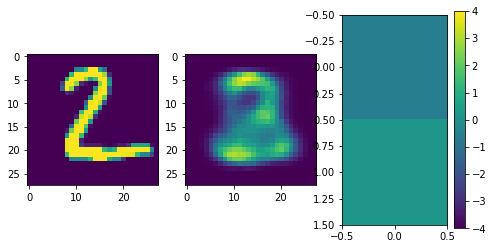

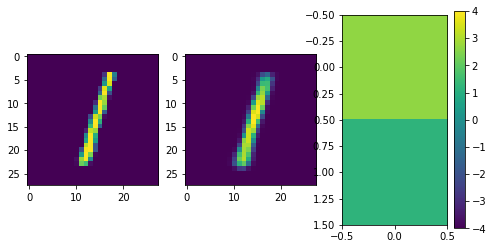

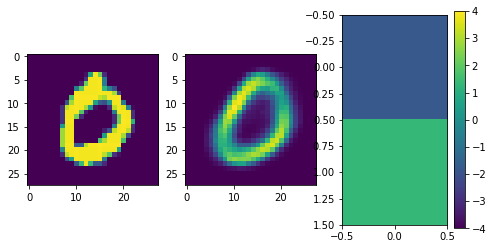

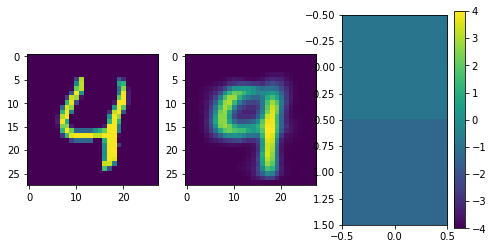

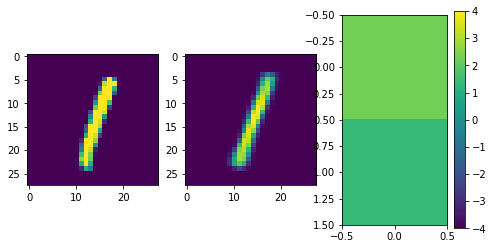

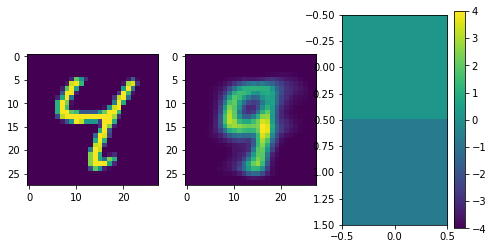

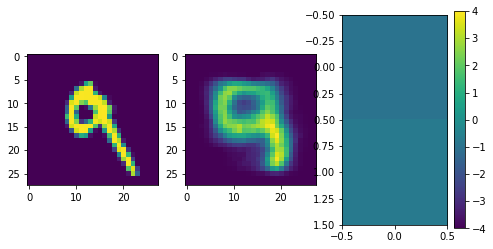

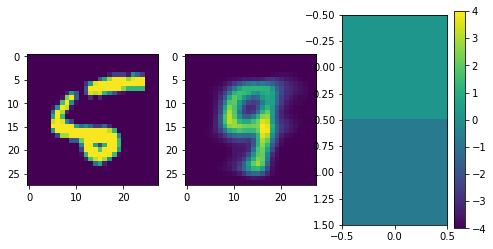

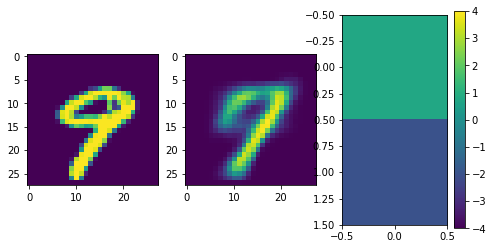

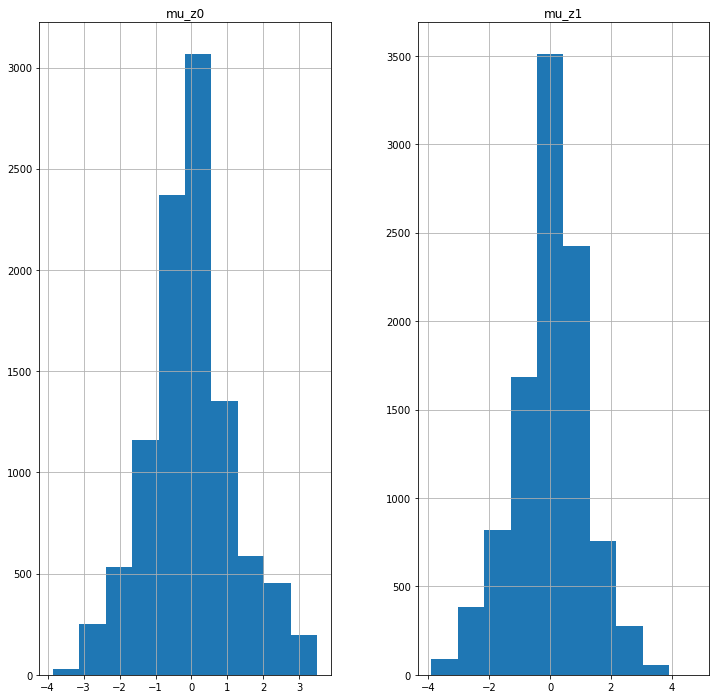

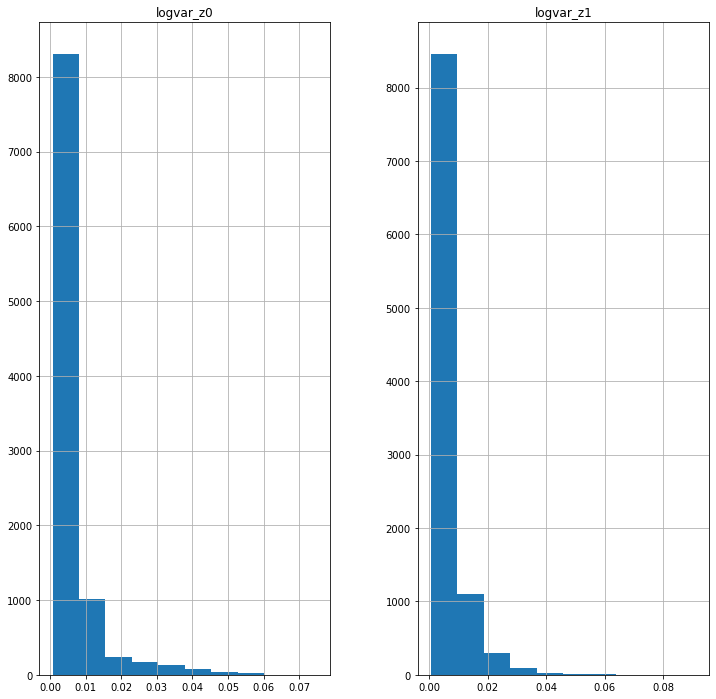

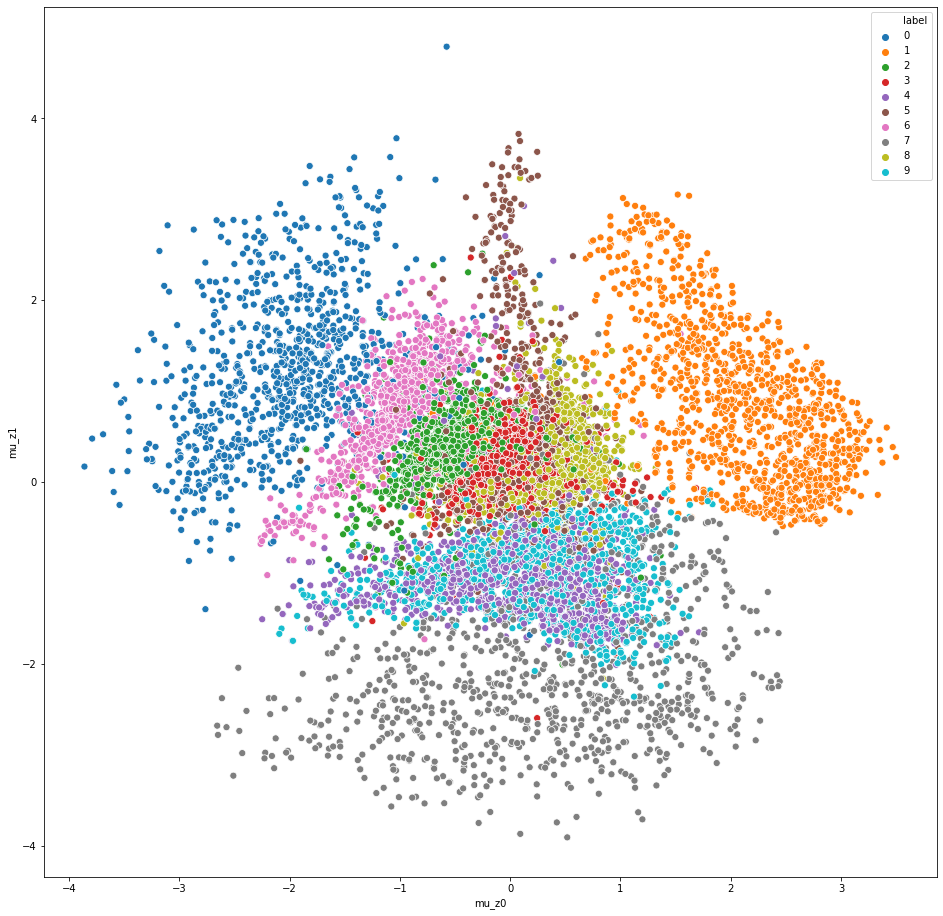

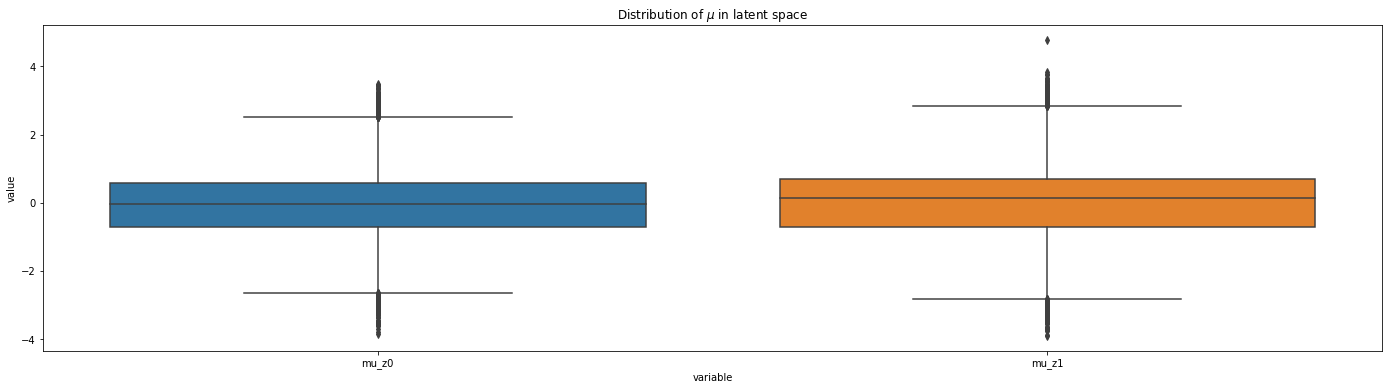

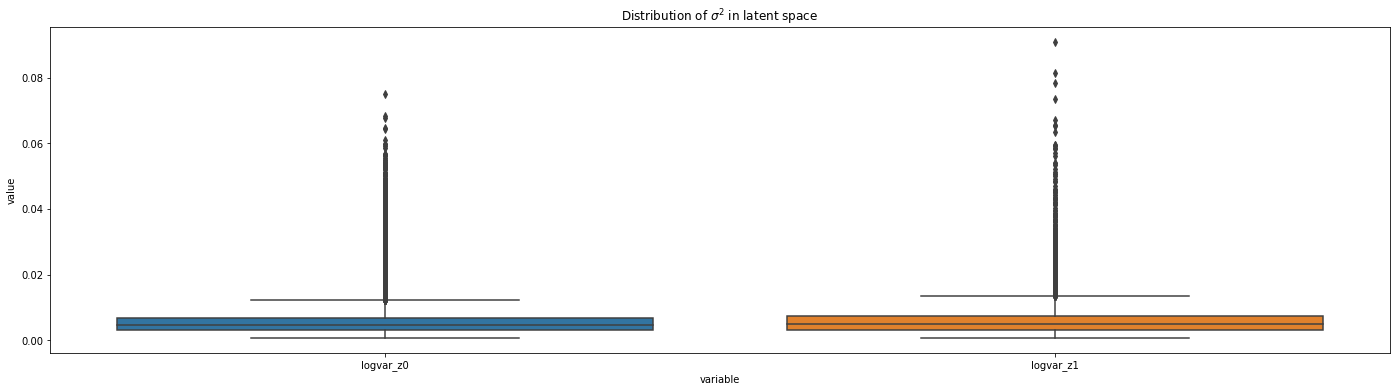

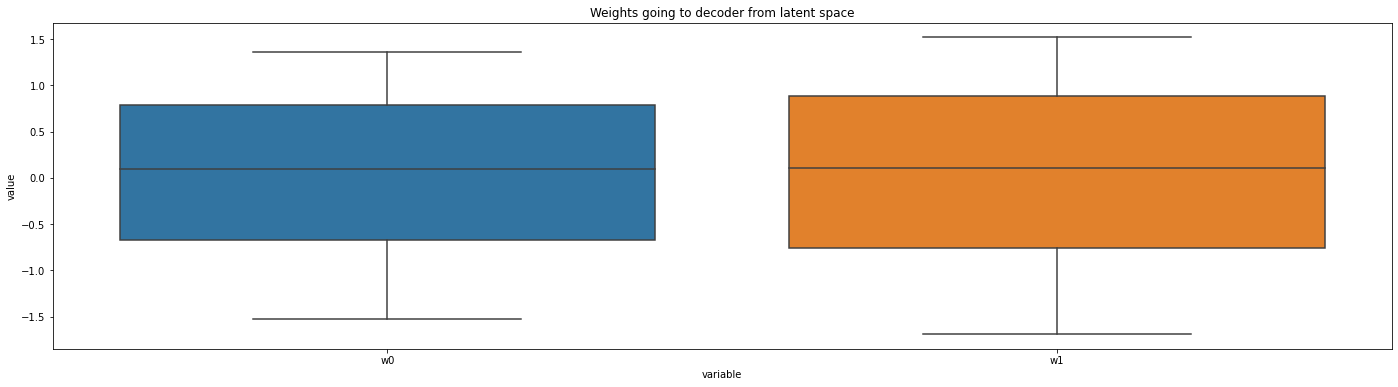

In [117]:
plot_reconstructions(model2, 'cuda', state_shape=(2, 1))

_, test_loader = prepare_data_loaders()
df_mu, df_logvar, df_dec1_weights = generate_latent_dataframes(model2, test_loader)
_ = df_mu.hist(figsize=(12,12))
_ = df_logvar.hist(figsize=(12,12))

plt.figure(figsize=(16, 16))
sns.scatterplot(x='mu_z0', y='mu_z1', hue='label', s=50, data=df_mu)
plot_data_boxplots(df_mu, df_logvar, df_dec1_weights)


# GAN


In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
from torchvision import datasets, transforms
import tqdm
from torchvision.utils import make_grid
import torch.distributions as tdist
import numpy as np
import tqdm
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import pdb 

In [0]:
def prepare_data_loaders(batch_size=32):
    train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./files', train=True, download=True, 
                               transform=torchvision.transforms.Compose([
                                   torchvision.transforms.Resize((64, 64)),
                                   torchvision.transforms.ToTensor()
                               ])), batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST('./files', train=False, download=True,
                                   transform=torchvision.transforms.Compose([
                                   torchvision.transforms.Resize((64, 64)),
                                       torchvision.transforms.ToTensor()
                                   ])), batch_size=batch_size)
    return train_loader, test_loader

In [35]:
class Generator(nn.Module):
    def __init__(self, latent_size, batch_norm=False):
        super().__init__()
        self.latent_size = latent_size
        if batch_norm:
          self.m = nn.Sequential(
            nn.ConvTranspose2d(in_channels=latent_size, out_channels=512, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(negative_slope=0.2),

            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(negative_slope=0.2),

            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(negative_slope=0.2),

            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(negative_slope=0.2),

            nn.ConvTranspose2d(in_channels=64, out_channels=1, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh())
        else:
          self.m = nn.Sequential(
            nn.ConvTranspose2d(in_channels=latent_size, out_channels=512, kernel_size=4, stride=1, padding=0, bias=False),
            nn.LeakyReLU(negative_slope=0.2),

            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(negative_slope=0.2),

            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(negative_slope=0.2),

            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(negative_slope=0.2),

            nn.ConvTranspose2d(in_channels=64, out_channels=1, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh())

    def forward(self, x):
      return self.m(x)

class Discriminator(nn.Module):
    def __init__(self, batch_norm=False):
        super().__init__()
        if batch_norm:
          self.m = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(negative_slope=0.2),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(negative_slope=0.2),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(negative_slope=0.2),

            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(negative_slope=0.2),

            nn.Conv2d(in_channels=512, out_channels=1, kernel_size=4, stride=2, padding=0, bias=False),
            nn.Sigmoid())
        else:
          self.m = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(negative_slope=0.2),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(negative_slope=0.2),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(negative_slope=0.2),

            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(negative_slope=0.2),

            nn.Conv2d(in_channels=512, out_channels=1, kernel_size=4, stride=2, padding=0, bias=False),
            nn.Sigmoid())
          
    def forward(self, x):
        return self.m(x)

def weights_init(w):
    classname = w.__class__.__name__
    if classname.find('conv') != -1:
        nn.init.normal_(w.weight.data, 0.0, 0.02)
    elif classname.find('bn') != -1:
        nn.init.normal_(w.weight.data, 1.0, 0.02)
        nn.init.constant_(w.bias.data, 0)

dmodel = Discriminator()
gmodel = Generator(100)

dmodel.apply(weights_init)
gmodel.apply(weights_init)

print(gmodel)
print(dmodel)

Generator(
  (m): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2)
    (2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): LeakyReLU(negative_slope=0.2)
    (4): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (5): LeakyReLU(negative_slope=0.2)
    (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): LeakyReLU(negative_slope=0.2)
    (8): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): Tanh()
  )
)
Discriminator(
  (m): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Conv2d(128, 256, kernel_siz

In [0]:
def train(gmodel: Generator, dmodel: Discriminator, n_epochs=10, log_epochs=1, batch_size=32, learning_rate=1e-3, device='cpu'):
    train_loader, test_loader = prepare_data_loaders(batch_size=batch_size)
    gmodel = gmodel.to(device)
    dmodel = dmodel.to(device)
    gmodel.train()
    dmodel.train()
    criterion = nn.BCELoss()
    g_optim = optim.Adam(gmodel.parameters(), lr=learning_rate, betas=(0.5, 0.999))
    d_optim = optim.Adam(dmodel.parameters(), lr=learning_rate, betas=(0.5, 0.999))
    for epoch_idx in range(0, n_epochs):
        g_loss, d_loss = 0, 0
        for image_data, _ in tqdm.tqdm(train_loader):
            # discriminator update
            dmodel.zero_grad()
            
            # real data pass
            image_data = image_data.to(device)
            
            batch_size = image_data.shape[0]
            labels = torch.ones(batch_size, device=device).float()

            d_output = dmodel(image_data)

            d_err_real = criterion(d_output, labels)
            d_err_real.backward()
            d_loss += d_err_real.item() / batch_size
            
            # fake data pass
            noise = torch.randn(batch_size, gmodel.latent_size, 1, 1, device=device)
            fake_image_data = gmodel(noise)
            labels = torch.zeros(batch_size, device=device).float()
            
            d_output = dmodel(fake_image_data.detach())
            d_error_fake = criterion(d_output, labels)
            d_error_fake.backward()
            d_loss += d_error_fake.item() / batch_size

            # diskriminator update
            d_optim.step()
            
            # generator update
            gmodel.zero_grad()
            
            labels = torch.ones(batch_size, device=device)
            d_output = dmodel(fake_image_data)
            g_error = criterion(d_output, labels)
            g_error.backward()
            g_loss += g_error.item() / batch_size 
            g_optim.step()
            
        if (epoch_idx + 1) % log_epochs == 0:
            print(f"[{epoch_idx+1}/{n_epochs}]: d_loss = {d_loss:.2f} g_loss {g_loss:.2f}")
    gmodel.eval()
    dmodel.eval()
    return gmodel, dmodel

In [0]:
gmodel, dmodel = train(gmodel, dmodel, n_epochs=15, batch_size=256, device='cuda')






  0%|          | 0/235 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:516: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1, 1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)




  0%|          | 1/235 [00:00<03:29,  1.12it/s]



  1%|          | 2/235 [00:01<03:24,  1.14it/s]



  1%|▏         | 3/235 [00:02<03:19,  1.16it/s]



  2%|▏         | 4/235 [00:03<03:13,  1.20it/s]



  2%|▏         | 5/235 [00:04<03:09,  1.21it/s]



  3%|▎         | 6/235 [00:04<03:04,  1.24it/s]



  3%|▎         | 7/235 [00:05<03:02,  1.25it/s]



  3%|▎         | 8/235 [00:06<03:00,  1.26it/s]



  4%|▍         | 9/235 [00:07<03:00,  1.25it/s]



  4%|▍         | 10/235 [00:08<02:57,  1.26it/s]



  5%|▍         | 11/235 [00:08<02:55,  1.27it/s]



  5%|▌         | 12/235 [00:09<02:53,  1.28it/s]



  6%

[1/15]: d_loss = 0.75 g_loss 1.14






  0%|          | 1/235 [00:00<03:05,  1.26it/s]



  1%|          | 2/235 [00:01<03:05,  1.26it/s]



  1%|▏         | 3/235 [00:02<03:04,  1.26it/s]



  2%|▏         | 4/235 [00:03<03:03,  1.26it/s]



  2%|▏         | 5/235 [00:04<03:04,  1.25it/s]



  3%|▎         | 6/235 [00:04<03:02,  1.25it/s]



  3%|▎         | 7/235 [00:05<03:01,  1.25it/s]



  3%|▎         | 8/235 [00:06<03:01,  1.25it/s]



  4%|▍         | 9/235 [00:07<03:00,  1.25it/s]



  4%|▍         | 10/235 [00:08<03:00,  1.25it/s]



  5%|▍         | 11/235 [00:08<02:59,  1.25it/s]



  5%|▌         | 12/235 [00:09<02:58,  1.25it/s]



  6%|▌         | 13/235 [00:10<02:56,  1.25it/s]



  6%|▌         | 14/235 [00:11<02:57,  1.25it/s]



  6%|▋         | 15/235 [00:11<02:55,  1.25it/s]



  7%|▋         | 16/235 [00:12<02:55,  1.25it/s]



  7%|▋         | 17/235 [00:13<02:54,  1.25it/s]



  8%|▊         | 18/235 [00:14<02:53,  1.25it/s]



  8%|▊         | 19/235 [00:15<02:52,  1.25it/s]



  9%|▊         | 

[2/15]: d_loss = 0.34 g_loss 63.73






  0%|          | 1/235 [00:00<02:58,  1.31it/s]



  1%|          | 2/235 [00:01<02:56,  1.32it/s]



  1%|▏         | 3/235 [00:02<02:55,  1.32it/s]



  2%|▏         | 4/235 [00:03<02:54,  1.32it/s]



  2%|▏         | 5/235 [00:03<02:53,  1.33it/s]



  3%|▎         | 6/235 [00:04<02:55,  1.31it/s]



  3%|▎         | 7/235 [00:05<02:53,  1.31it/s]



  3%|▎         | 8/235 [00:06<02:53,  1.31it/s]



  4%|▍         | 9/235 [00:06<02:53,  1.30it/s]



  4%|▍         | 10/235 [00:07<02:53,  1.30it/s]



  5%|▍         | 11/235 [00:08<02:51,  1.30it/s]



  5%|▌         | 12/235 [00:09<02:53,  1.29it/s]



  6%|▌         | 13/235 [00:09<02:50,  1.30it/s]



  6%|▌         | 14/235 [00:10<02:50,  1.29it/s]



  6%|▋         | 15/235 [00:11<02:49,  1.30it/s]



  7%|▋         | 16/235 [00:12<02:48,  1.30it/s]



  7%|▋         | 17/235 [00:13<02:47,  1.30it/s]



  8%|▊         | 18/235 [00:13<02:47,  1.29it/s]



  8%|▊         | 19/235 [00:14<02:45,  1.31it/s]



  9%|▊         | 

[3/15]: d_loss = 0.00 g_loss 92.43






  0%|          | 1/235 [00:00<02:56,  1.32it/s]



  1%|          | 2/235 [00:01<02:56,  1.32it/s]



  1%|▏         | 3/235 [00:02<02:55,  1.32it/s]



  2%|▏         | 4/235 [00:03<02:54,  1.32it/s]



  2%|▏         | 5/235 [00:03<02:53,  1.32it/s]



  3%|▎         | 6/235 [00:04<02:53,  1.32it/s]



  3%|▎         | 7/235 [00:05<02:53,  1.32it/s]



  3%|▎         | 8/235 [00:06<02:52,  1.32it/s]



  4%|▍         | 9/235 [00:06<02:51,  1.32it/s]



  4%|▍         | 10/235 [00:07<02:51,  1.32it/s]



  5%|▍         | 11/235 [00:08<02:50,  1.32it/s]



  5%|▌         | 12/235 [00:09<02:50,  1.31it/s]



  6%|▌         | 13/235 [00:09<02:49,  1.31it/s]



  6%|▌         | 14/235 [00:10<02:48,  1.31it/s]



  6%|▋         | 15/235 [00:11<02:46,  1.32it/s]



  7%|▋         | 16/235 [00:12<02:45,  1.32it/s]



  7%|▋         | 17/235 [00:12<02:44,  1.32it/s]



  8%|▊         | 18/235 [00:13<02:44,  1.32it/s]



  8%|▊         | 19/235 [00:14<02:43,  1.32it/s]



  9%|▊         | 

[4/15]: d_loss = 0.00 g_loss 92.43






  0%|          | 1/235 [00:00<02:56,  1.32it/s]



  1%|          | 2/235 [00:01<02:55,  1.33it/s]



  1%|▏         | 3/235 [00:02<02:54,  1.33it/s]



  2%|▏         | 4/235 [00:03<02:53,  1.33it/s]



  2%|▏         | 5/235 [00:03<02:54,  1.32it/s]



  3%|▎         | 6/235 [00:04<02:52,  1.33it/s]



  3%|▎         | 7/235 [00:05<02:52,  1.33it/s]



  3%|▎         | 8/235 [00:06<02:51,  1.33it/s]



  4%|▍         | 9/235 [00:06<02:51,  1.32it/s]



  4%|▍         | 10/235 [00:07<02:49,  1.33it/s]



  5%|▍         | 11/235 [00:08<02:49,  1.32it/s]



  5%|▌         | 12/235 [00:09<02:47,  1.33it/s]



  6%|▌         | 13/235 [00:09<02:47,  1.33it/s]



  6%|▌         | 14/235 [00:10<02:45,  1.34it/s]



  6%|▋         | 15/235 [00:11<02:45,  1.33it/s]



  7%|▋         | 16/235 [00:12<02:44,  1.33it/s]



  7%|▋         | 17/235 [00:12<02:45,  1.32it/s]



  8%|▊         | 18/235 [00:13<02:43,  1.32it/s]



  8%|▊         | 19/235 [00:14<02:43,  1.32it/s]



  9%|▊         | 

[5/15]: d_loss = 0.00 g_loss 92.42






  0%|          | 1/235 [00:00<03:02,  1.28it/s]



  1%|          | 2/235 [00:01<02:59,  1.30it/s]



  1%|▏         | 3/235 [00:02<02:57,  1.30it/s]



  2%|▏         | 4/235 [00:03<02:56,  1.31it/s]



  2%|▏         | 5/235 [00:03<02:55,  1.31it/s]



  3%|▎         | 6/235 [00:04<02:53,  1.32it/s]



  3%|▎         | 7/235 [00:05<02:52,  1.32it/s]



  3%|▎         | 8/235 [00:06<02:51,  1.32it/s]



  4%|▍         | 9/235 [00:06<02:51,  1.32it/s]



  4%|▍         | 10/235 [00:07<02:50,  1.32it/s]



  5%|▍         | 11/235 [00:08<02:49,  1.32it/s]



  5%|▌         | 12/235 [00:09<02:48,  1.33it/s]



  6%|▌         | 13/235 [00:09<02:47,  1.32it/s]



  6%|▌         | 14/235 [00:10<02:46,  1.33it/s]



  6%|▋         | 15/235 [00:11<02:45,  1.33it/s]



  7%|▋         | 16/235 [00:12<02:44,  1.33it/s]



  7%|▋         | 17/235 [00:12<02:44,  1.33it/s]



  8%|▊         | 18/235 [00:13<02:42,  1.33it/s]



  8%|▊         | 19/235 [00:14<02:42,  1.33it/s]



  9%|▊         | 

[6/15]: d_loss = 0.00 g_loss 92.39






  0%|          | 1/235 [00:00<02:54,  1.34it/s]



  1%|          | 2/235 [00:01<02:55,  1.33it/s]



  1%|▏         | 3/235 [00:02<02:54,  1.33it/s]



  2%|▏         | 4/235 [00:03<02:54,  1.32it/s]



  2%|▏         | 5/235 [00:03<02:52,  1.33it/s]



  3%|▎         | 6/235 [00:04<02:52,  1.33it/s]



  3%|▎         | 7/235 [00:05<02:51,  1.33it/s]



  3%|▎         | 8/235 [00:06<02:50,  1.33it/s]



  4%|▍         | 9/235 [00:06<02:49,  1.34it/s]



  4%|▍         | 10/235 [00:07<02:49,  1.33it/s]



  5%|▍         | 11/235 [00:08<02:47,  1.33it/s]



  5%|▌         | 12/235 [00:09<02:47,  1.33it/s]



  6%|▌         | 13/235 [00:09<02:46,  1.34it/s]



  6%|▌         | 14/235 [00:10<02:46,  1.33it/s]



  6%|▋         | 15/235 [00:11<02:44,  1.34it/s]



  7%|▋         | 16/235 [00:12<02:45,  1.32it/s]



  7%|▋         | 17/235 [00:12<02:43,  1.33it/s]



  8%|▊         | 18/235 [00:13<02:43,  1.33it/s]



  8%|▊         | 19/235 [00:14<02:42,  1.33it/s]



  9%|▊         | 

[7/15]: d_loss = 0.00 g_loss 92.36






  0%|          | 1/235 [00:00<02:56,  1.33it/s]



  1%|          | 2/235 [00:01<02:55,  1.33it/s]



  1%|▏         | 3/235 [00:02<02:54,  1.33it/s]



  2%|▏         | 4/235 [00:03<02:54,  1.32it/s]



  2%|▏         | 5/235 [00:03<02:53,  1.32it/s]



  3%|▎         | 6/235 [00:04<02:54,  1.31it/s]



  3%|▎         | 7/235 [00:05<02:54,  1.31it/s]



  3%|▎         | 8/235 [00:06<02:52,  1.31it/s]



  4%|▍         | 9/235 [00:06<02:51,  1.32it/s]



  4%|▍         | 10/235 [00:07<02:51,  1.31it/s]



  5%|▍         | 11/235 [00:08<02:50,  1.31it/s]



  5%|▌         | 12/235 [00:09<02:49,  1.32it/s]



  6%|▌         | 13/235 [00:09<02:48,  1.32it/s]



  6%|▌         | 14/235 [00:10<02:47,  1.32it/s]



  6%|▋         | 15/235 [00:11<02:47,  1.32it/s]



  7%|▋         | 16/235 [00:12<02:45,  1.32it/s]



  7%|▋         | 17/235 [00:12<02:44,  1.32it/s]



  8%|▊         | 18/235 [00:13<02:43,  1.33it/s]



  8%|▊         | 19/235 [00:14<02:42,  1.33it/s]



  9%|▊         | 

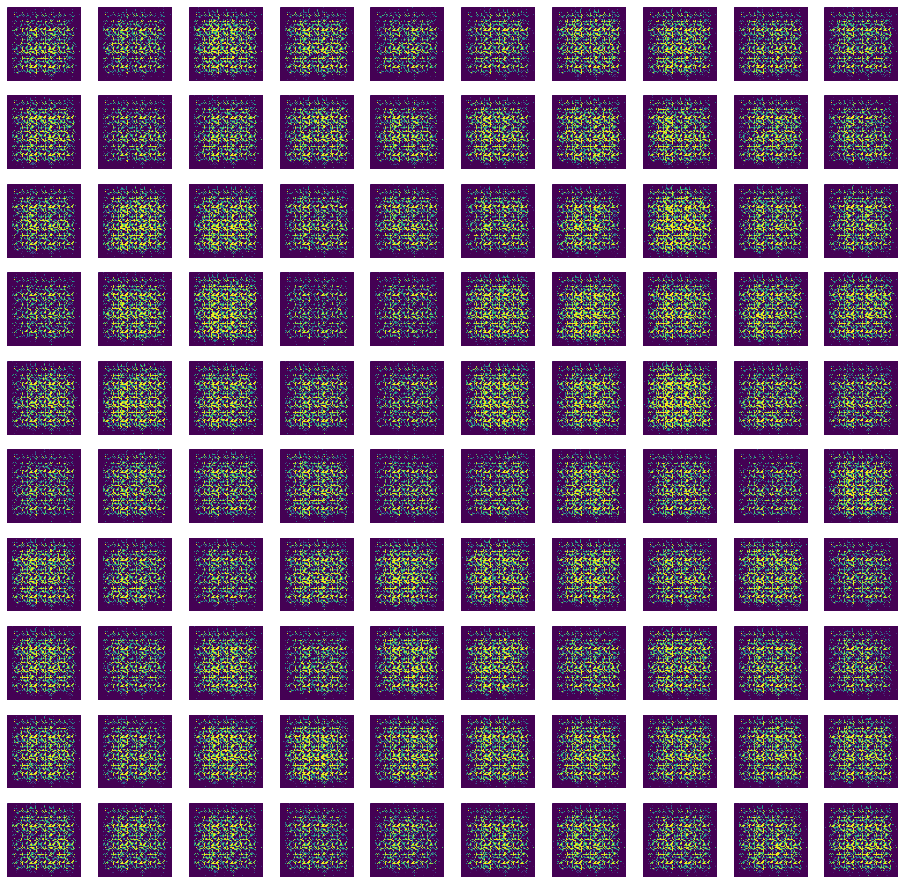

In [30]:
random_sample = gmodel(torch.randn(100, 100, 1, 1).to('cuda')).view(100, 64, 64).data.cpu().numpy()

plt.figure(figsize=(16, 16))
for idx in range(0, 100):
    plt.subplot(10, 10, idx+1)
    plt.imshow(random_sample[idx, ...])
    plt.clim(0, 1)
    plt.axis('off')